# Marketing A/B Testing

Presentation slides:
- https://docs.google.com/presentation/d/1POkoPpT-aI3VVVqPBBu3gfIOAySIEPgp3Cg-2iCyNI4/edit#slide=id.g33e85632fb6_0_665

## 1. About the Dataset

<h3> 1.1. Marketing A/B testing dataset </h3>

Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

- Would the campaign be successful?
- If the campaign was successful, how much of that success could be attributed to the ads?

With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

<h3> 1.2. Data dictionary </h3>

- **Index**: Row index
- **user id**: User ID (unique)
- **test group**: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- **converted**: If a person bought the product then True, else is False
- **total ads**: Amount of ads seen by person
- **most ads day**: Day that the person saw the biggest amount of ads
- **most ads hour**: Hour of day that the person saw the biggest amount of ads

<h3> 1.3. References </h3>

- Boslaugh, S. (2012) Statistics in a Nutshell: A Desktop Quick Reference. 2nd edn. Sebastopol, CA: O'Reilly Media, pp. 127–130, 273–279, 312, 367–379.
- Faviovázquez. (20 Oct 2021). [Marketing A/B Testing](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data). Last accessed: 02 March 2025
- Six Sigma Pro SMART. (29 Dec 2023). [Complete guide to hands-on A/B Testing | A/B testing in Python | All that you need to know](https://www.youtube.com/watch?v=AQC7b68H7LU). Last accessed: 02 March 2025

## 2. Import | Libraries & data

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
from kagglehub import KaggleDatasetAdapter

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data from Kaggle
file_path = "marketing_AB.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "faviovaz/marketing-ab-testing",
  file_path
)

<h2> 3. Explore Data </h2>

In [3]:
# Check raw dataset
 
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [4]:
# Summary statistics 

df.describe().round(1)

,Unnamed: 0,user id,total ads,most ads hour
count,588101.0,588101.0,588101.0,588101.0
mean,294050.0,1310692.2,24.8,14.5
std,169770.3,202226.0,43.7,4.8
min,0.0,900000.0,1.0,0.0
25%,147025.0,1143190.0,4.0,11.0
50%,294050.0,1313725.0,13.0,14.0
75%,441075.0,1484088.0,27.0,18.0
max,588100.0,1654483.0,2065.0,23.0


In [5]:
# Data types 

df.dtypes

Unnamed: 0        int64
user id           int64
test group       object
converted          bool
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

In [6]:
# All columns seem to be categorical in type except total adds
## test_group = psa | ad
## converted = true | false
## most ads day = day of week
## most ads hour = hour of day

df.nunique()

Unnamed: 0       588101
user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64

In [7]:
# Check unique categorical choices for each column
## Are they unique? (yes)
## Do they make sense? (yes)

print(df["test group"].unique())

print(df["converted"].unique())

print(df["most ads day"].unique())

print(sorted(df["most ads hour"].unique()))

['ad' 'psa']
[False  True]
['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [8]:
# Check for duplicate rows (across all columns per row)
## There are none. No action needed.

print(f"Total duplicate rows: {df.duplicated().sum()}")
print(df[df.duplicated(keep=False)])

Total duplicate rows: 0
Empty DataFrame
Columns: [Unnamed: 0, user id, test group, converted, total ads, most ads day, most ads hour]
Index: []


In [9]:
# Check if there are any duplicated users
## No duplicate users, so we can drop this.

df.duplicated(subset="user id").sum()

0

<h2> 4. Clean data </h2>

<h3> 4.1. Drop unneeded columns </h3>

In [10]:
# Drop index column
## It has no value

df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [11]:
# Drop user id column
## As there are no duplicates user_id, this field doesn't bring us any extra value.
## The value lies in the test group and whether they were converted or not

df.drop("user id",axis=1,inplace=True)
df.head()

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14


<h2> 5. Visualisation </h2>

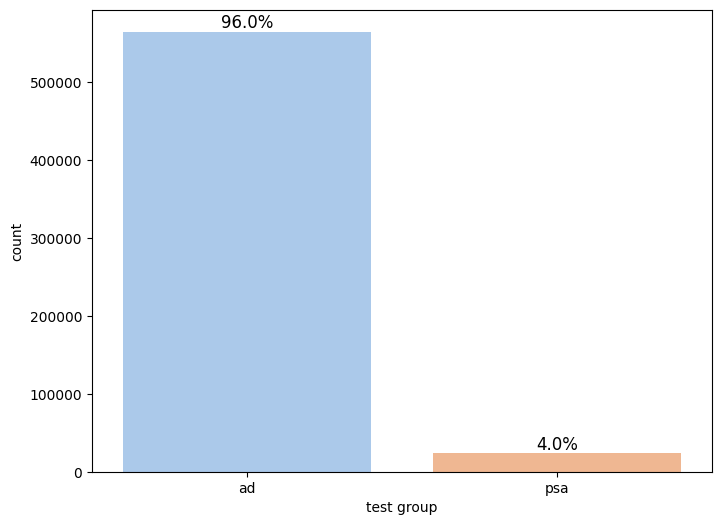

In [12]:
# [Univariate] TEST GROUP

category = "test group"

# Set the figure size
plt.figure(figsize=(8, 6))

total = len(df)  # Total number of rows
ax = sns.countplot(data=df, x=category, palette='pastel')

# Annotate bars with percentages
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"  # Format percentage
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

In [13]:
# [Tabular] TEST GROUP vs. CONVERTED 

category = "test group"

# Create a crosstab with counts
ct_test_group = pd.crosstab(df[category],df["converted"],normalize='index')

# Display the crosstab
ct_test_group


converted,False,True
test group,,
ad,0.974453,0.025547
psa,0.982146,0.017854


<Axes: xlabel='test group'>

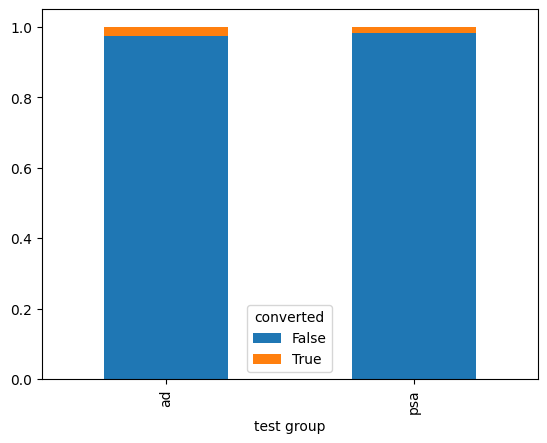

In [14]:
# [Graph] TEST GROUP vs. CONVERTED
ct_test_group.plot.bar(stacked=True)

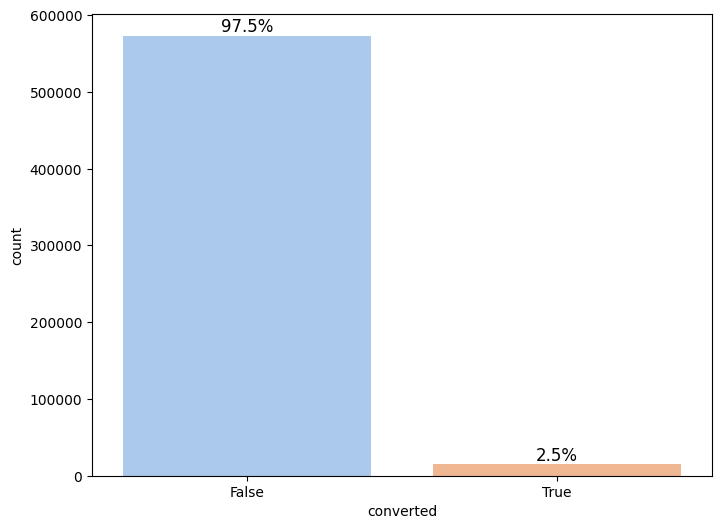

In [15]:
# [Univariate] CONVERTED

category = "converted"

# Set the figure size
plt.figure(figsize=(8, 6))

total = len(df)  # Total number of rows
ax = sns.countplot(data=df, x=category, palette='pastel')

# Annotate bars with percentages
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"  # Format percentage
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

In [16]:
# [Tabular] CONVERTED vs. CONVERTED
category = "converted"

# Create a crosstab with counts
ct_converted = pd.crosstab(df[category],df["converted"],normalize=True)

# Display the crosstab
ct_converted


converted,False,True
converted,,
False,0.974761,0.000000
True,0.000000,0.025239


<Axes: xlabel='converted'>

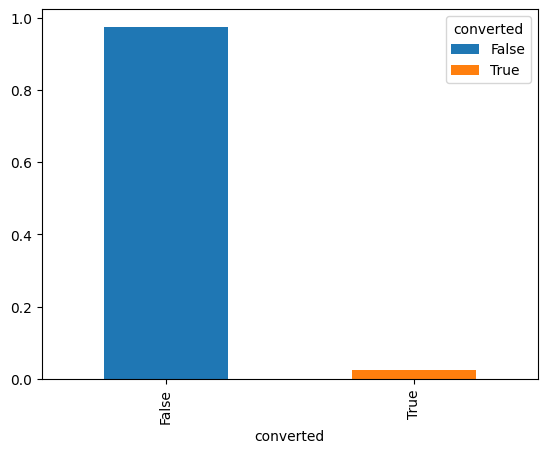

In [17]:
# [Graph] CONVERTED vs. CONVERTED
ct_converted.plot.bar(stacked=True)

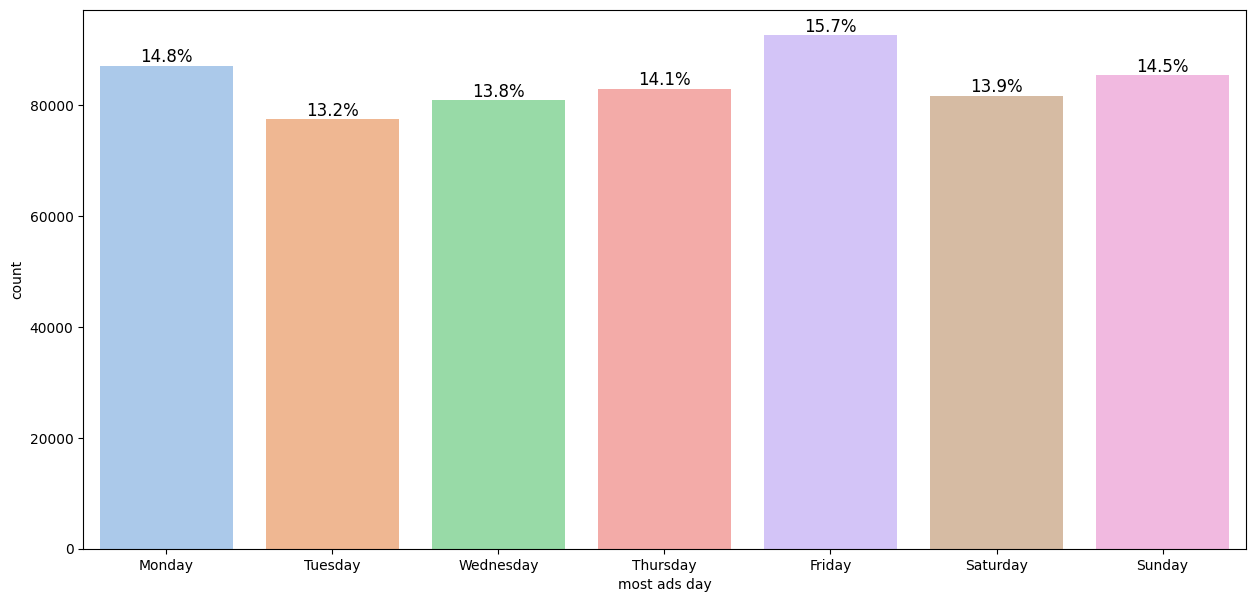

In [18]:
# [Univariate] MOST ADS DAY 

category = "most ads day"

# Set the figure size
plt.figure(figsize=(15, 7))

# Ensure the 'most ads day' column is a categorical type with the correct order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

total = len(df)  # Total number of rows
ax = sns.countplot(data=df, x=category, palette='pastel', order=days_order)

# Annotate bars with percentages
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"  # Format percentage
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

In [19]:
# [Tabular] MOST ADS DAY vs. CONVERTED

category = "most ads day"

# Create a crosstab with counts
ct_most_ads_day = pd.crosstab(df[category],df["converted"],normalize= 'index')

# Display the crosstab
ct_most_ads_day.sort_values(by=True, ascending=False)

converted,False,True
most ads day,,
Monday,0.967188,0.032812
Tuesday,0.970160,0.029840
Wednesday,0.975058,0.024942
Sunday,0.975524,0.024476
Friday,0.977788,0.022212
Thursday,0.978429,0.021571
Saturday,0.978949,0.021051


<Axes: xlabel='most ads day'>

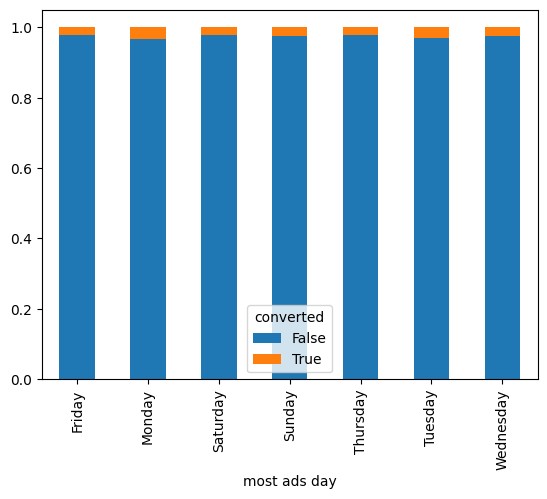

In [20]:
# [Graph] MOST ADS DAY vs. CONVERTED

ct_most_ads_day.plot.bar(stacked=True)

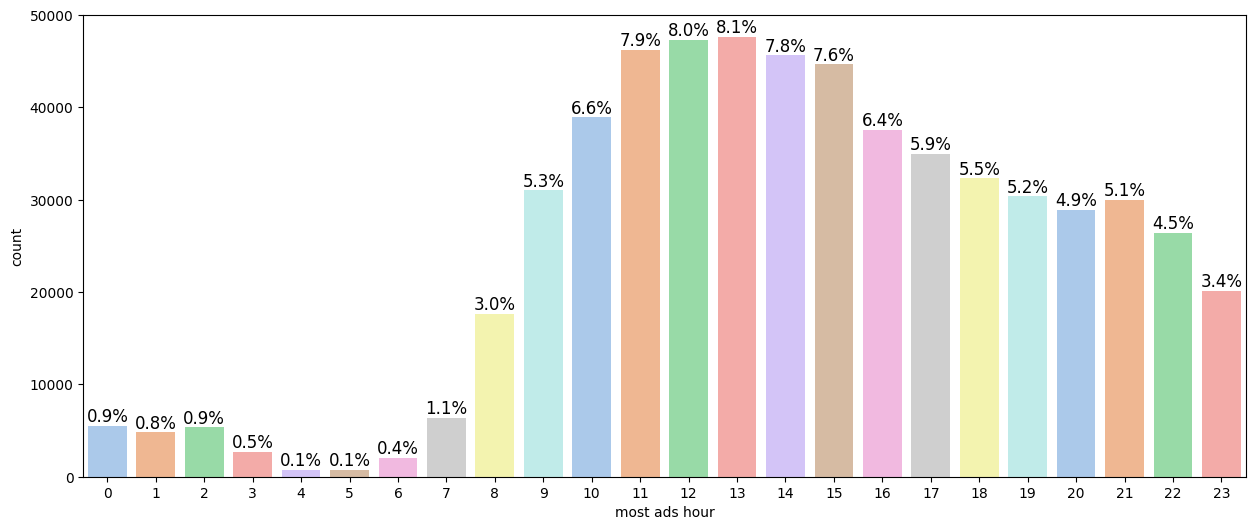

In [21]:
# [Univariate] MOST ADS HOUR 

category = "most ads hour"

# Set the figure size
plt.figure(figsize=(15, 6))

total = len(df)  # Total number of rows
ax = sns.countplot(data=df, x=category, palette="pastel")

# Annotate bars with percentages
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"  # Format percentage
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

In [22]:
# [Tabular] ADS HOUR vs. CONVERTED

# More people likely to convert at 16, 20, 15, 21, 17, 14, 18, 19, 22, 13, 12, 23, 6, 11, 10, 5 hours

category = "most ads hour"

# Create a crosstab with counts
ct_most_ads_hour = pd.crosstab(df[category],df["converted"],normalize='index')

# Display the crosstab
ct_most_ads_hour.sort_values(by=True, ascending=False)

converted,False,True
most ads hour,,
16,0.969228,0.030772
20,0.970197,0.029803
15,0.970347,0.029653
21,0.971077,0.028923
17,0.971790,0.028210
14,0.971937,0.028063
18,0.972620,0.027380
19,0.973280,0.026720
22,0.973895,0.026105


<Axes: xlabel='most ads hour'>

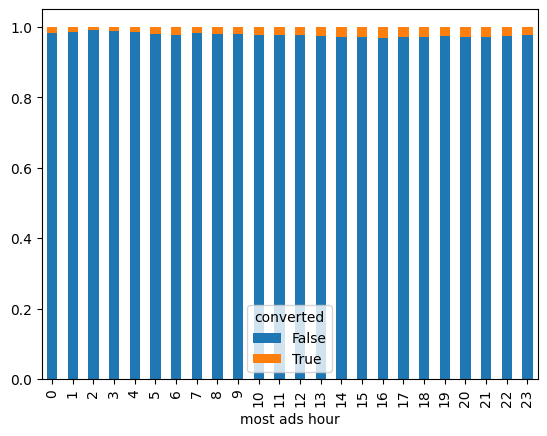

In [23]:
# [Graph] ADS HOUR vs CONVERTED 

## Adds between 10am and 12pm seem to have the highest conversion
### It makes sense due to the average sleep patterns

ct_most_ads_hour.plot.bar(stacked=True)


<Axes: xlabel='converted', ylabel='total ads'>

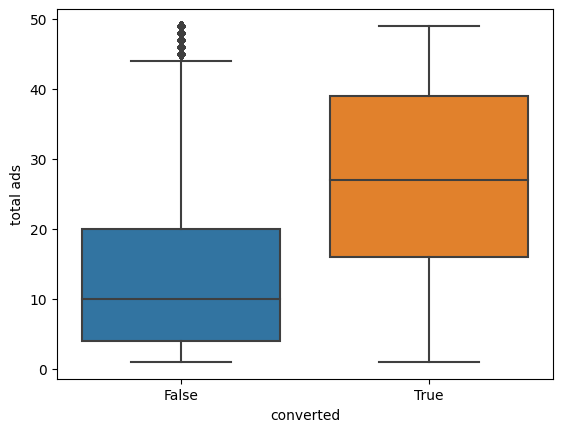

In [24]:
# [Boxplot] Converted vs. Total adds (< 50)
## Converted people on the whole have seen more adds (~28) than non-converted people (~10)
## Under 50 selected to reduce skewness

sns.boxplot(x="converted", y="total ads", data = df[df["total ads"]<50])

<h2> 6. Statistical Testing </h2>

<h3> 6.1. A/B Test Methodology </h3>

**Aim**: To run an A/B test and measure if the "ad" group is more likely to be converted than the "psa" group

- **Filter the Data:** You’ll need to separate the data into two groups: one for the "ad" group and one for the "psa" group.
- **Define the Hypothesis:**
    - **Null Hypothesis (H0)**: There is no difference in the conversion rates between the "ad" and "psa" groups.
    - **Alternative Hypothesis (H1)**: The "ad" group has a higher conversion rate than the "psa" group.
- **Perform the Statistical Test**: The most common test to compare two proportions (like conversion rates) is the Chi-square test for independence or Z-test for proportions.
- **Calculate the Conversion Rates**: You will calculate the conversion rates for both groups.
- **Check for Statistical Significance**: You’ll then compare the p-value from the test to your significance level (typically 0.05) to determine if the difference in conversion rates is statistically significant.

<h3> 6.2. Test Group vs. Converted </h3>

**Aim:** to answer our initial question. 

- **Question:** Was the campaign successful?
- (**Answer:** ✅ Yes)

In [25]:
# Step 1: Separate the groups
ad_group = df[df['test group'] == 'ad']
psa_group = df[df['test group'] == 'psa']

# Step 2: Calculate the conversion rate for each group
ad_conversion_rate = ad_group['converted'].mean()
psa_conversion_rate = psa_group['converted'].mean()

print("[CHAI-SQUARED TEST FOR TEST GROUP VS. CONVERTED]")

print(f"\n\033[1mTEST GROUP\033[0m")
print(f"| • Conversion rate for 'ad' group: {ad_conversion_rate}")
print(f"| • Conversion rate for 'psa' group: {psa_conversion_rate}")

# Step 3: Run a statistical test (Chi-square test)
# First, create a contingency table of the form [ [ad_converted, ad_not_converted], [psa_converted, psa_not_converted] ]
contingency_table = pd.crosstab(df['test group'], df['converted'])

# Perform Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"| • Chi-square stat: {chi2_stat.round(2)}")
print(f"| • p-value (6 decimals): {p_value:.6f}")
print(f"| • P-value: {p_value:.20f}")

# Step 4: Interpret the results
if p_value < 0.05:
    print("| --------------\n| ✅ SIGNIFICANT: Reject the null hypothesis. There is a significant difference in conversion rates between the 'ad' and 'psa' groups.")
    print(f"| • \033[1mAnswers question:\033[0m  Does being in the ad group or PSA group impact conversion rates? \n"
          f"| • \033[1mNull Hypothesis (H₀):\033[0m  Conversion rates do not differ between the test groups (ad vs. PSA). \n"
          f"| • \033[1mAlternative Hypothesis (H₁):\033[0m  Conversion rates do differ between the test groups. \n"
          f"| • \033[1mSignificant result:\033[0m  Means that conversion rates differ between users who saw ads and those who saw PSAs, indicating that ads likely had an impact on conversions.")
else:
    print("SIGNIFICANCE: ❌ Fail to reject the null hypothesis. There is no significant difference in conversion rates.")


[CHAI-SQUARED TEST FOR TEST GROUP VS. CONVERTED]

TEST GROUP
| • Conversion rate for 'ad' group: 0.025546559636683747
| • Conversion rate for 'psa' group: 0.01785410644448223
| • Chi-square stat: 54.01
| • p-value (6 decimals): 0.000000
| • P-value: 0.00000000000019989623
| --------------
| ✅ SIGNIFICANT: Reject the null hypothesis. There is a significant difference in conversion rates between the 'ad' and 'psa' groups.
| • Answers question:  Does being in the ad group or PSA group impact conversion rates? 
| • Null Hypothesis (H₀):  Conversion rates do not differ between the test groups (ad vs. PSA). 
| • Alternative Hypothesis (H₁):  Conversion rates do differ between the test groups. 
| • Significant result:  Means that conversion rates differ between users who saw ads and those who saw PSAs, indicating that ads likely had an impact on conversions.


<h4> 6.2.1. Explanation </h4>

- **Data Filtering:** We filter the data into ad_group and psa_group.
- **Conversion Rates:** The conversion rate is calculated by taking the mean of the converted column (True = 1, False = 0) for each group.
- **Chi-square Test:** We use scipy.stats.chi2_contingency() to run a Chi-square test for independence. This test is used here because we are comparing two categorical variables (test group and conversion).
- **Decision:** If the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant difference in conversion rates between the two groups.

<h3> 6.3. [A/B] Categorical variables vs. Converted </h3>

**Aim:** To provide greater marketing insights

**Insights:** 

- Time of day makes a difference. Focus on the times of day that are most heavily viewed.
    - [5, 6] Pre-working day
    - [10, 11, 12, 13, 14, 15, 16, 17] Working day
    - [18, 19, 20, 21, 22, 23] Post-working day
- Day of the week makes a difference
    - Friday > Monday > Sunday > [rest of week]

In [26]:
df_categorical_variables = df[["test group", "converted", "most ads day", "most ads hour"]]

alpha = 0.05

print("[CHAI-SQUARED TEST FOR EACH {VARIABLE} VS. CONVERTED]")

for variable in df_categorical_variables.columns:
    if variable != 'converted':
        # Create a contingency table (cross-tab)
        contingency_table = pd.crosstab(df_categorical_variables[variable],df_categorical_variables["converted"])
        
        # Chi-squared test
        chi2,p, _, _ = chi2_contingency(contingency_table)
        
        # Results
        print(f"\n\033[1m{variable.upper()}\033[0m")
        print(f"| • Chi-squared value: {chi2.round(2)}")
        print(f"| • p-value (6 decimals): {p:.6f}")
        print(f"| • p-value: {p:.90f}")
        
        # Significance check
        
        if p < alpha:
            print(f"| --------------\n| ✅ SIGNIFICANT: Reject the null hypothesis. There is a significant difference in conversion rates across the variable: {variable}")
            
            if variable == 'test group':
                print(f"| • \033[1mAnswers question:\033[0m  Does being in the ad group or PSA group impact conversion rates? \n"
                    f"| • \033[1mNull Hypothesis (H₀):\033[0m  Conversion rates do not differ between the test groups (ad vs. PSA). \n"
                    f"| • \033[1mAlternative Hypothesis (H₁):\033[0m  Conversion rates do differ between the test groups. \n"
                    f"| • \033[1mSignificant result:\033[0m  Means that conversion rates differ between users who saw ads and those who saw PSAs, indicating that ads likely had an impact on conversions.")
                
            if variable == 'most ads day':
                print(f"| • \033[1mAnswers question:\033[0m  Does the day of the week where a user saw the most ads impact conversion rates? \n"
                    f"| • \033[1mNull Hypothesis (H₀):\033[0m  Conversion rates do not differ across days. \n"
                    f"| • \033[1mAlternative Hypothesis (H₁):\033[0m  Conversion rates do differ depending on the most ads day. \n"
                    f"| • \033[1mSignificant result:\033[0m  Means that conversion rates vary depending on the most ads day (e.g., users who see the most ads on Fridays might convert more than those who see them on Mondays).")
                
            if variable == 'most ads hour':
                print(f"| • \033[1mAnswers question:\033[0m  Does the hour where a user saw the most ads impact conversion rates? \n"
                    f"| • \033[1mNull Hypothesis (H₀):\033[0m  Conversion rates do not depend on the hour of the most ads. \n"
                    f"| • \033[1mAlternative Hypothesis (H₁):\033[0m  Conversion rates do depend on the most ads hour. \n"
                    f"| • \033[1mSignificant result:\033[0m  Means that conversion rates differ depending on the hour users see the most ads (e.g., people exposed to ads at 10 AM might convert more than those at 3 AM).")

        else:
            print(f"| ❌ NOT SIGNIFICANT: Fail to reject the null hypothesis. There is no significant difference in conversion rates with the following variable: {variable}.")
        

[CHAI-SQUARED TEST FOR EACH {VARIABLE} VS. CONVERTED]

TEST GROUP
| • Chi-squared value: 54.01
| • p-value (6 decimals): 0.000000
| • p-value: 0.000000000000199896230633900750665031738938025026257718289035558711930207209661602973937988
| --------------
| ✅ SIGNIFICANT: Reject the null hypothesis. There is a significant difference in conversion rates across the variable: test group
| • Answers question:  Does being in the ad group or PSA group impact conversion rates? 
| • Null Hypothesis (H₀):  Conversion rates do not differ between the test groups (ad vs. PSA). 
| • Alternative Hypothesis (H₁):  Conversion rates do differ between the test groups. 
| • Significant result:  Means that conversion rates differ between users who saw ads and those who saw PSAs, indicating that ads likely had an impact on conversions.

MOST ADS DAY
| • Chi-squared value: 410.05
| • p-value (6 decimals): 0.000000
| • p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000

<h3> 6.4. [A/B] Numerical variables vs. Converted </h3>

**Aim:** To provide greater marketing insights

**Insight(s):**

- The analysis suggests that there is a **significant difference** in the "total ads" between users who converted (`True`) and those who did not (`False`).

In [27]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

alpha = 0.05

# Check assumptions
print("[NORMALITY AND EQUALITY OF VARIANCES ASSUMPTIONS]")

## Normality Assumption
shapiro_stat_true, shapiro_p_value_true = shapiro(df[df['converted'] == True]["total ads"])
shapiro_stat_false, shapiro_p_value_false = shapiro(df[df['converted'] == False]["total ads"])

print(f"\n\033[1mShapiro-Wilk Test for Normality (True group)\033[0m")
print(f"| • p-value: {shapiro_p_value_true:.6f}")
print(f"\033[1mShapiro-Wilk Test for Normality (False group)\033[0m")
print(f"| • p-value: {shapiro_p_value_false:.6f}")

# Equality of variances assumption
levene_stat, levene_p_value = levene(df[df['converted']]["total ads"], df[~df['converted']]['total ads'])

print(f"\n\033[1mLevene's Test for Equality of Variances\033[0m")
print(f"| • p-value: {levene_p_value:.6f}")

# Perform statistical test
print("\n[STATISTICAL TEST SELECTION]")

if shapiro_p_value_true > alpha and shapiro_p_value_false > alpha and levene_p_value > alpha:
    # Assumptions met - use t-test for means
    t_stat, t_p_value = ttest_ind(df[df['converted']]['total ads'],df[~df['converted']]['total ads'])
    print(f"\n\033[1mIndependent Two-Sample t-test\033[0m")
    print(f"| • p-value: {t_p_value:.6f}")
    print(f"| ✅ SIGNIFICANT: The conversion rates between the 'True' and 'False' groups differ significantly based on the t-test for means.")

else:
    # Assumptions not met - use Mann-Whitney U test for medians
    u_stat, u_p_value = mannwhitneyu(df[df['converted']]['total ads'],df[~df['converted']]['total ads'])
    print(f"\n\033[1mMann-Whitney U Test\033[0m")
    print(f"| • p-value: {u_p_value:.6f}")
    print(f"| ✅ SIGNIFICANT: The conversion rates between the 'True' and 'False' groups differ significantly based on the Mann-Whitney U test for medians.")


[NORMALITY AND EQUALITY OF VARIANCES ASSUMPTIONS]

Shapiro-Wilk Test for Normality (True group)
| • p-value: 0.000000
Shapiro-Wilk Test for Normality (False group)
| • p-value: 0.000000

Levene's Test for Equality of Variances
| • p-value: 0.000000

[STATISTICAL TEST SELECTION]

Mann-Whitney U Test
| • p-value: 0.000000
| ✅ SIGNIFICANT: The conversion rates between the 'True' and 'False' groups differ significantly based on the Mann-Whitney U test for medians.


<h4> 6.4.1. Interpretation </h4>

##### 6.4.1.1 **Shapiro-Wilk Test for Normality** (for both the True and False groups):

- **True group p-value = 0.000000**
- **False group p-value = 0.000000**

**Interpretation**:
- The Shapiro-Wilk test is used to check if the data is normally distributed.
- The p-value for both the "True" and "False" groups is **0.000000**, which is **much smaller** than the typical alpha level of 0.05.
- **❌ Conclusion**: You **reject the null hypothesis** for both groups. This means that the data for both groups (True and False) are **not normally distributed**.



##### 6.4.1.2. **Levene's Test for Equality of Variances**:

- **p-value = 0.000000**

**Interpretation**:
- Levene's test checks if the variances of the two groups are equal.
- The p-value is **0.000000**, which is also **much smaller** than 0.05.
- **❌ Conclusion**: You **reject the null hypothesis**. This means the variances of the two groups (True and False) are **not equal**.



##### 6.4.1.3. **Mann-Whitney U Test**:

- **p-value = 0.000000**

**Interpretation**:
- Since the assumptions of normality and equal variances were not met, the Mann-Whitney U test was used. This test compares the medians of the two groups (True vs. False).
- The p-value of **0.000000** indicates a **highly significant difference** between the two groups.
- **✅ Conclusion**: There is a significant difference in the distributions (and medians) of the "total ads" between the "True" and "False" groups.



##### 6.4.1.4. **Overall Interpretation**:

- **Conclusion**
  - ✅ The analysis suggests that there is a **significant difference** in the "total ads" between users who converted (`True`) and those who did not (`False`).

- **Assumptions**:
  - The data are **not normally distributed** for either group.
  - The **variances are not equal** between the groups.
  
- **Statistical Test**:
  - Because the assumptions for a t-test (normality and equal variances) were not met, you used the **Mann-Whitney U Test**, which is a non-parametric test for comparing two independent groups.
  - The p-value for the **Mann-Whitney U Test** is extremely small (0.000000), indicating that there is a **statistically significant difference** in the "total ads" between the "True" and "False" groups.


<Axes: xlabel='converted', ylabel='total ads'>

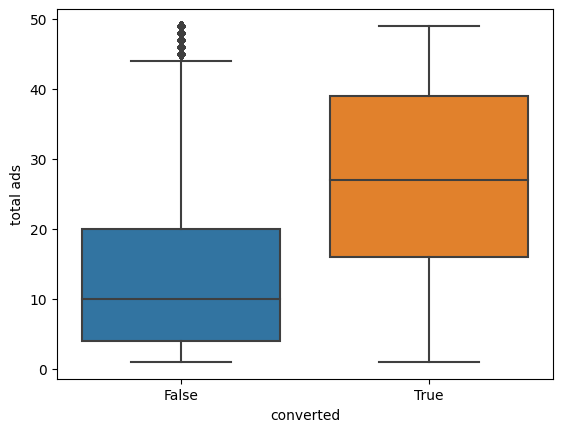

In [28]:
# [Boxplot] Converted vs. Total adds (< 50)
## Converted people on the whole have seen more adds (~28 median) than non-converted people (~10 median)
## Under 50 selected to reduce skewness (akin to using the median/mann-whitey U test in our statistical test choice (due to skewed means))

sns.boxplot(x="converted", y="total ads", data = df[df["total ads"]<50])

<h3> 6.5. Impact of Ads on Conversion Rates </h3>
<h5> <b>Question:</b> If the campaign was successful, how much of that success could be attributed to the ads? </h5>

> **🚀 Conversion Rate**
> 
> - **Conversion Rate** is the percentage of users who take a desired action (convert) out of the total users who were exposed to a campaign, website, or product.  
>
> **📊 Formula**
> - $
> \text{Conversion Rate} = \left( \frac{\text{Number of Conversions}}{\text{Total Number of Users (or Visitors)}} \right) \times 100
> $
>
> **🤔 Example**
> 
> - If **10,000** people visit a website and **500** of them make a purchase, the conversion rate is:
>
>    - $
> \text{Conversion Rate} = \left( \frac{500}{10,000} \right) \times 100 = 5\%
> $
> 
> - This means **5% of visitors converted** (i.e., made a purchase).  
>
> **🤷‍♂️ Where Is It Used?**
> 
> - Marketing Campaigns: How many users who saw an ad actually bought the product?
> - Websites: How many visitors signed up for a newsletter?
> - Apps: How many free users upgraded to a paid plan?
> - E-commerce: How many people added items to their cart and completed checkout?
>
> A higher conversion rate means your campaign or website is more effective at convincing users to take action.

<h4> 6.5.1. Compare Conversion Rates Between Ad Group and PSA Group </h4>

**❗️Note:** We should first check that these differences are statistically valid. However, we did this above, so will not repeat this step.



In [29]:
# Compare Conversion Rates Between Ad Group and PSA Group

# Calculate conversion rates for both 'ad' and 'psa' groups
ad_group_conversion_rate = df[df['test group'] == 'ad']['converted'].mean()
psa_group_conversion_rate = df[df['test group'] == 'psa']['converted'].mean()

# Display the conversion rates
print(f"Conversion rate for 'ad' group: {ad_group_conversion_rate:.10f} | {ad_group_conversion_rate*100:.10f}% ")
print(f"Conversion rate for 'psa' group: {psa_group_conversion_rate:.10f} | {psa_group_conversion_rate*100:.10f}% ")

# Calculate the difference in conversion rates
conversion_rate_diff = ad_group_conversion_rate - psa_group_conversion_rate
print(f"Difference in conversion rates (ad - psa): {conversion_rate_diff:.10f} | {conversion_rate_diff*100:.10f}%")

Conversion rate for 'ad' group: 0.0255465596 | 2.5546559637% 
Conversion rate for 'psa' group: 0.0178541064 | 1.7854106444% 
Difference in conversion rates (ad - psa): 0.0076924532 | 0.7692453192%


<h4> 6.5.2. Simple Difference </h4>

> **Formula**
> 
> - $
> \text{attribution\_percentage} = \left( \frac{\text{conversion\_rate\_diff}}{\text{ad\_group\_conversion\_rate}} \right) \times 100
> $
> 
> - **Sub-formulas**
> 
>   - **conversion_rate_diff** = Difference in conversion rates between the ad group and PSA group
>
>        - `conversion_rate_diff = ad_group_conversion_rate − psa_group_conversion_rate`
>   - **ad_group_conversion_rate** = Conversion rate of users who saw ads
>
> **What is this formula doing?**
>
> This formula calculates what percentage of conversions in the ad group can be attributed to the ads themselves.
>
> > **Step 1: Measure the "Lift"**
>
> The numerator (`conversion_rate_diff`) represents the increase in conversions due to ads.  
> 
> If the ad group converts at 2.5547% and the PSA group converts at 1.7854%, then:
>
> $ \text{conversion\_rate\_diff} = 2.5547\% - 1.7854\% = 0.7692\% $  
>
> This 0.7692% represents the extra conversions potentially driven by the ads.
>
> > **Step 2: Normalize by the Ad Group Conversion Rate**
>
> Instead of just saying "ads caused 0.7692% more conversions," we want to express this as a proportion of all conversions in the ad group.  
>
> If 2.5547% of users in the ad group converted, we want to know what fraction of those 2.5547% were due to ads:
>
> $ \frac{0.7692\%}{2.5547\%} = 0.3011 $  
>
> > **Step 3: Convert to Percentage**
>
> Multiply by 100 to get the final attribution percentage:
>
> $ 0.3011 \times 100 = 30.11\% $  
>
> This means 30.11% of the conversions in the ad group can be attributed to the ads.
>
> > **Example Calculation**
>
> | Group      | Conversion Rate |
> |------------|-----------------|
> | Ad Group   | 2.5547% (0.0255465596)       |
> | PSA Group  | 1.7854% (0.0178541064)       |
>
> $ \text{conversion\_rate\_diff} = 0.0255465596 - 0.0178541064 = 0.0076924532 $  
>
> $ \text{attribution\_percentage} = \left( \frac{0.0076924532}{0.0255465596} \right) \times 100 = 30.11\% $  
>
> So, in this case, **30.11%** of the conversions in the ad group can be attributed to the ads.
>
> > **Why Does This Work?**
>
> Instead of just reporting the raw lift (`conversion_rate_diff`), this approach scales it relative to the total conversions in the ad group.  
>
> This makes it easier to interpret:
> - If the attribution percentage is high (e.g., 80%), ads were the primary driver of conversions.
> - If the attribution percentage is low (e.g., 10%), many conversions might have happened regardless of the ads.
> > **Limitations**
> - This formula assumes that all conversion rate differences are due to ads, which might not be entirely true (other external factors could be at play).
> - It doesn't account for other potential influences, like seasonality, user intent, or organic trends.
>
> But as a quick estimation, it's a useful way to measure how much of the ad group’s success can be credited to ads. 


In [30]:
# Estimate Attribution to Ads (Simple Difference)

# Calculate the attribution percentage
attribution_percentage = (conversion_rate_diff / ad_group_conversion_rate) * 100

# Display the attribution percentage
print(f"\nEstimated Attribution to Ads: {attribution_percentage:.2f}%")



Estimated Attribution to Ads: 30.11%


<h4> 6.5.3 Logistic Regression </h4>

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Ensure that 'converted' is numeric (1 for True, 0 for False)
df['converted'] = df['converted'].astype(int)

# Create a binary column for ad exposure (1 for ad, 0 for psa)
df['ad_exposure'] = (df['test group'] == 'ad').astype(int)

# Logistic regression model (ad_exposure vs. converted)
model = logit("converted ~ ad_exposure", data=df).fit()

# Display the regression results
print("\nLogistic Regression Model:")
print(model.summary())

# The coefficient for 'ad_exposure' will indicate the impact of ads exposure on the conversion probability


Optimization terminated successfully.
         Current function value: 0.117730
         Iterations 8

Logistic Regression Model:
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               588101
Model:                          Logit   Df Residuals:                   588099
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:               0.0004342
Time:                        09:49:59   Log-Likelihood:                -69237.
converged:                       True   LL-Null:                       -69267.
Covariance Type:            nonrobust   LLR p-value:                 8.800e-15
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.0075      0.049    -81.393      0.000      -4.104      -3.91

**Model Summary**

- **Intercept**: The intercept value is -4.0075, which represents the log-odds of conversion when `ad_exposure = 0` (i.e., when users are in the PSA group). A negative value indicates that the odds of conversion for the PSA group are lower than the baseline.
  
- **ad_exposure**: The coefficient for `ad_exposure` is 0.3661. This means that when a user is in the "ad" group (vs. the PSA group), the log-odds of conversion increase by 0.3661. In other words, users who are exposed to ads are more likely to convert compared to users who see PSAs.

**Statistical Significance**

- **p-value for ad_exposure**: The p-value for `ad_exposure` is 0.000, which is less than 0.05. This indicates that the result is statistically significant, meaning that there is a significant relationship between ad exposure and conversion rates. In other words, ad exposure has a measurable impact on conversion likelihood.

<h4> 6.5.4 Odds Ratio </h4>

You can also interpret the `ad_exposure` coefficient as an odds ratio. To do this, you exponentiate the coefficient:

> An odds ratio (OR) is a measure used in statistics to quantify the strength of association or non-randomness between two binary (dichotomous) outcomes.
>
> Such as whether someone converted or not after being exposed to an ad. 
>
> It compares the odds of an event happening in one group to the odds of the same event happening in another group.
>
> **General Odds Ratio Formula:**
>
> - $ \text{Odds} = \left( \frac{\text{Probability of event}}{\text{Probability of non-event}} \right) $
> 
> or alternatively:
> 
> - $ \text{Odds} = \left( \frac{\text{Probability of non-event}}{\text{Probability of event}} \right) $
> 
> **Odds Ratio Formula using a co-efficient**
>
> - $ \text{Odds Ratio (OR)} = e^{\beta_1} $
>  
>  In our case:
>  - $ \text{Odds Ratio} = e^{0.3661} = 1.442 $

In [33]:
# Calculate Odds Ratio
odds_ratio = np.exp(model.params['ad_exposure'])
print(f"Odds Ratio for ad_exposure: {odds_ratio:.3f}")

Odds Ratio for ad_exposure: 1.442


**Interpretation of Odds Ratio**

- The Odds Ratio for ad_exposure is 1.442. 
- This means that users exposed to ads are 44.2% more likely to convert compared to users who are exposed to PSAs.
- In other words, the presence of ads significantly increases the likelihood of conversion relative to seeing a PSA.

<h2> 7. Conclusion </h2>

- **Lift:** 0.75% difference between the control group and the ad group.
- **Attribution Percentage:** 30% increase in conversions (assuming ads are the only influencing factor).
- **Odds ratio:** Odds of conversion are 44% higher for those exposed to ads.